In [55]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [56]:
!pip install keras

# Setting

In [57]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [220, 220]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 128
EPOCHS = 49

print(ROOT_PATH)

/aiffel/aiffel


In [58]:
# 추가로 import해야 할 패키지들을 먼저 가져옵니다. 
from tensorflow.keras import backend, regularizers, initializers, models

# block 안에 반복적으로 활용되는 L2 regularizer를 선언해 줍니다.
def _gen_l2_regularizer(use_l2_regularizer=True, l2_weight_decay=1e-4):
  return regularizers.l2(l2_weight_decay) if use_l2_regularizer else None


# Dataset

In [59]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [60]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [61]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [62]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [63]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [64]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [65]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 인풋이미지 형태로만들기-->IMAGE_SIZE

In [66]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [67]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [68]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (220, 220, 3)
Label:  False


In [69]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [70]:


# def augment(image,label):
#     image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
#     return image,label

# def prepare_for_training(ds, shuffle_buffer_size=1000):
#     # augment 적용 부분이 배치처리 함수에 추가되었습니다.
#     ds = ds.map(
#             augment,       # augment 함수 적용
#             num_parallel_calls=2
#         )
#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#     ds = ds.repeat()
#     ds = ds.batch(BATCH_SIZE)
#     ds = ds.prefetch(buffer_size=AUTOTUNE)

#     return ds

# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds)

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# label_batch 나오는 코드 

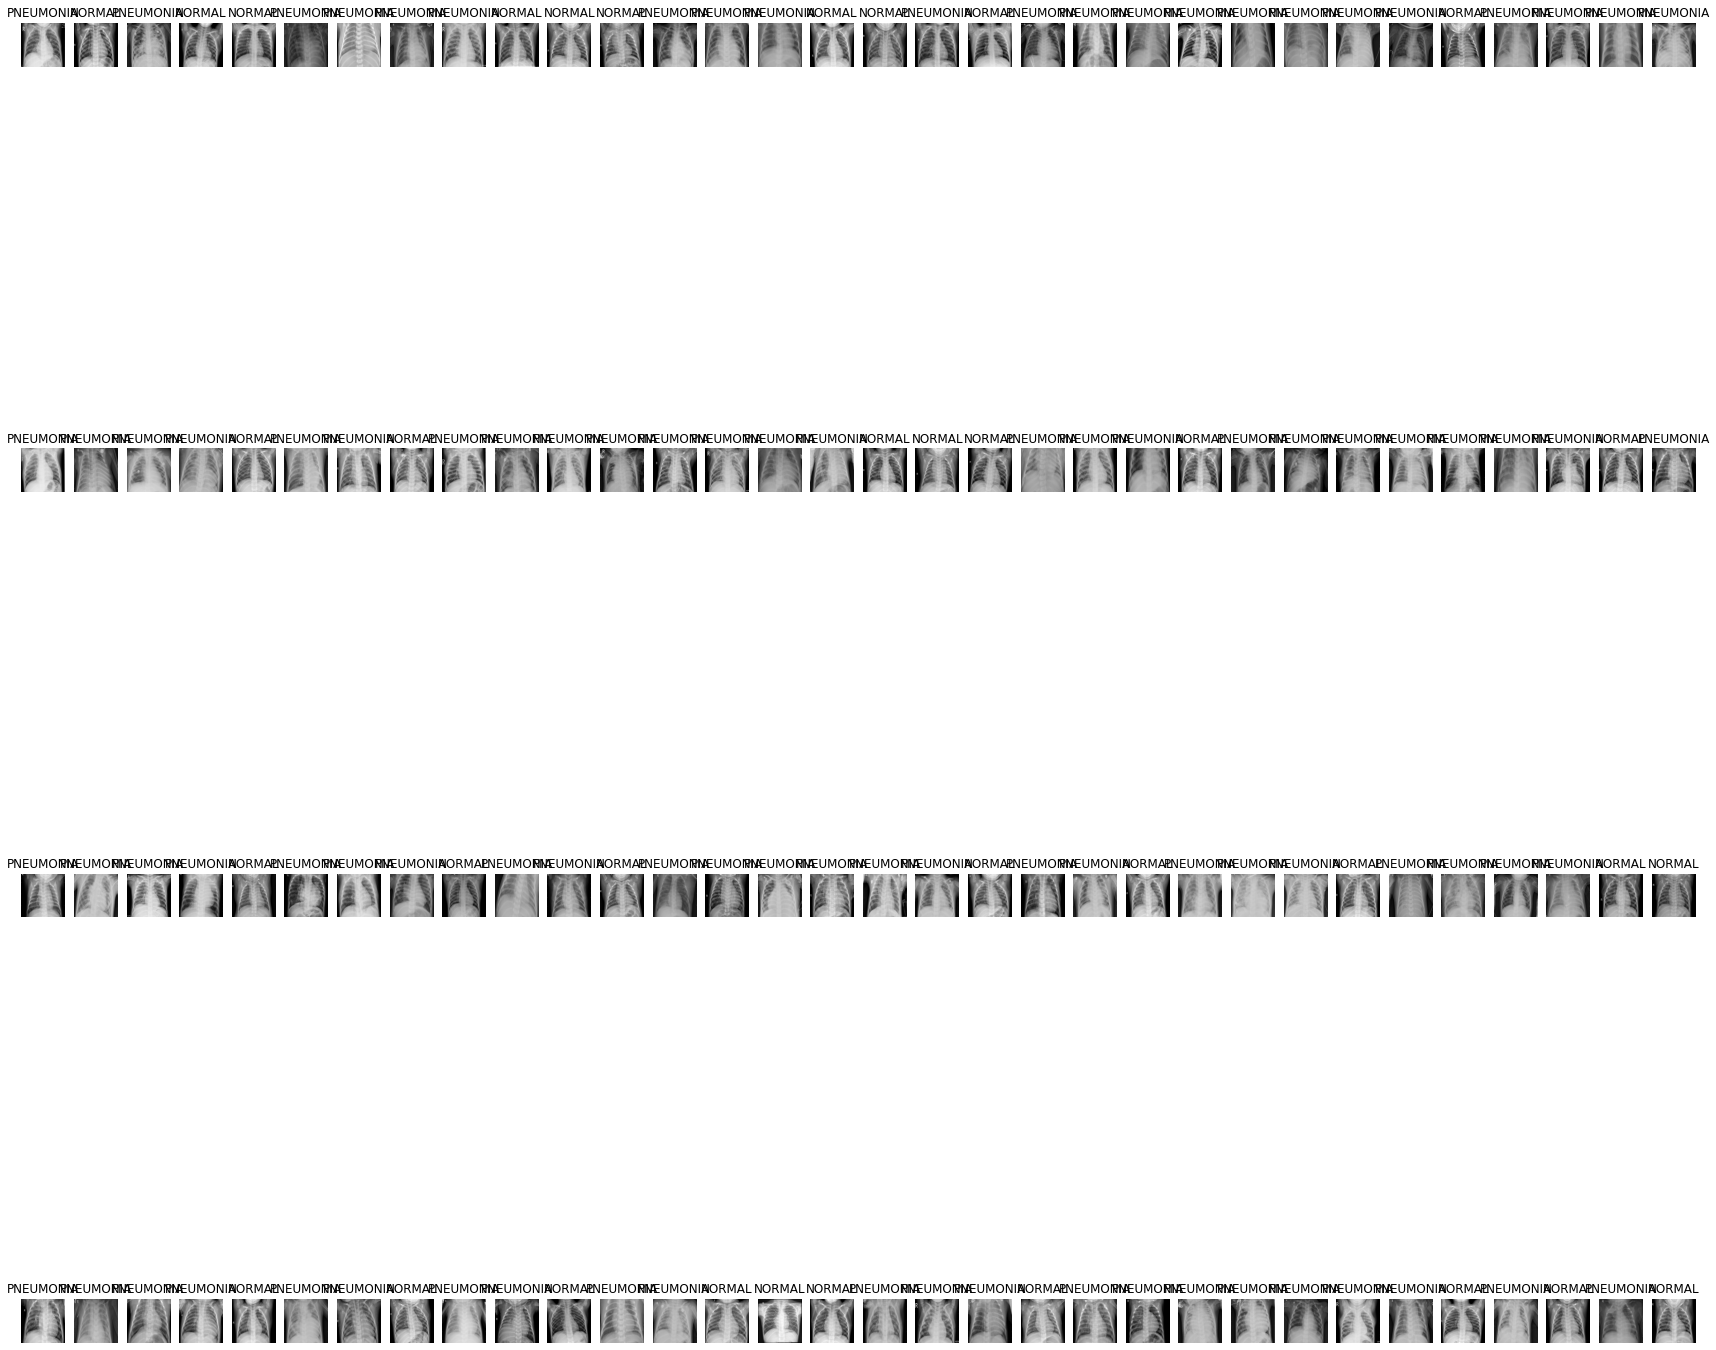

In [71]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(30,30))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())



In [72]:
# from tensorflow.keras.utils import to_categorical


# one_hot = to_categorical(label_batch)
# one_hot = to_categorical(image_batch)

# batch size 가 64개라 위와 같이 64개의 데이터가 나온다. 

In [73]:
def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2),
               use_l2_regularizer=True,
               batch_norm_decay=0.9,
               batch_norm_epsilon=1e-5):
  """A block that has a conv layer at shortcut.
  Note that from stage 3,
  the second conv layer at main path is with strides=(2, 2)
  And the shortcut should have strides=(2, 2) as well
  Args:
    input_tensor: input tensor
    kernel_size: default 3, the kernel size of middle conv layer at main path
    filters: list of integers, the filters of 3 conv layer at main path
    stage: integer, current stage label, used for generating layer names
    block: 'a','b'..., current block label, used for generating layer names
    strides: Strides for the second conv layer in the block.
    use_l2_regularizer: whether to use L2 regularizer on Conv layer.
    batch_norm_decay: Moment of batch norm layers.
    batch_norm_epsilon: Epsilon of batch borm layers.
  Returns:
    Output tensor for the block.
  """
  filters1, filters2, filters3 = filters
  if backend.image_data_format() == 'channels_last':
    bn_axis = 3
  else:
    bn_axis = 1
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  x = layers.Conv2D(
      filters1, (1, 1), 
      use_bias=False,
      kernel_initializer='he_normal',#relu 계열 kernel init= he_normal 
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '2a')(
          input_tensor)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '2a')(
          x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(
      filters2,
      kernel_size,
      strides=strides,
      padding='same',
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '2b')(
          x)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '2b')(
          x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(
      filters3, (1, 1),
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '2c')(
          x)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '2c')(
          x)

  shortcut = layers.Conv2D(
      filters3, (1, 1),
      strides=strides,
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '1')(
          input_tensor)
  shortcut = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '1')(
          shortcut)

  x = layers.add([x, shortcut])
  x = layers.Activation('relu')(x)
  return x

In [74]:
def identity_block(input_tensor,
                   kernel_size,
                   filters,
                   stage,
                   block,
                   use_l2_regularizer=True,
                   batch_norm_decay=0.9,
                   batch_norm_epsilon=1e-5):
  """The identity block is the block that has no conv layer at shortcut.
  Args:
    input_tensor: input tensor
    kernel_size: default 3, the kernel size of middle conv layer at main path
    filters: list of integers, the filters of 3 conv layer at main path
    stage: integer, current stage label, used for generating layer names
    block: 'a','b'..., current block label, used for generating layer names
    use_l2_regularizer: whether to use L2 regularizer on Conv layer.
    batch_norm_decay: Moment of batch norm layers.
    batch_norm_epsilon: Epsilon of batch borm layers.
  Returns:
    Output tensor for the block.
  """
  filters1, filters2, filters3 = filters
  if backend.image_data_format() == 'channels_last':
    bn_axis = 3
  else:
    bn_axis = 1
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  x = layers.Conv2D(
      filters1, (1, 1),
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '2a')(
          input_tensor)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '2a')(
          x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(
      filters2,
      kernel_size,
      padding='same',
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '2b')(
          x)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '2b')(
          x)
  x = layers.Activation('relu')(x)

  x = layers.Conv2D(
      filters3, (1, 1),
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name=conv_name_base + '2c')(
          x)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name=bn_name_base + '2c')(
          x)

  x = layers.add([x, input_tensor])
  x = layers.Activation('relu')(x)
  return x

In [75]:

from tensorflow.keras import layers
img_input = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
def resnet50(num_classes,
             batch_size=None,
             use_l2_regularizer=True,
             rescale_inputs=False,
             batch_norm_decay=0.9,
             batch_norm_epsilon=1e-5):
  """Instantiates the ResNet50 architecture.
  Args:
    num_classes: `int` number of classes for image classification.
    batch_size: Size of the batches for each step.
    use_l2_regularizer: whether to use L2 regularizer on Conv/Dense layer.
    rescale_inputs: whether to rescale inputs from 0 to 1.
    batch_norm_decay: Moment of batch norm layers.
    batch_norm_epsilon: Epsilon of batch borm layers.
  Returns:
      A Keras model instance.
  """

  input_shape = (220, 220, 3)  # CIFAR100을 위한 input_shape 조정입니다. 
  img_input = layers.Input(shape=input_shape, batch_size=batch_size)
  if rescale_inputs:
    # Hub image modules expect inputs in the range [0, 1]. This rescales these
    # inputs to the range expected by the trained model.
    x = layers.Lambda(
        lambda x: x * 255.0 - backend.constant(
            imagenet_preprocessing.CHANNEL_MEANS,
            shape=[1, 1, 3],
            dtype=x.dtype),
        name='rescale')(
            img_input)
  else:
    x = img_input

  if backend.image_data_format() == 'channels_first':
    x = layers.Permute((3, 1, 2))(x)
    bn_axis = 1
  else:  # channels_last
    bn_axis = 3

  block_config = dict(
      use_l2_regularizer=use_l2_regularizer,
      batch_norm_decay=batch_norm_decay,
      batch_norm_epsilon=batch_norm_epsilon)
  x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(x)
  x = layers.Conv2D(
      64, (7, 7),
      strides=(2, 2),
      padding='valid',
      use_bias=False,
      kernel_initializer='he_normal',
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name='conv1')(
          x)
  x = layers.BatchNormalization(
      axis=bn_axis,
      momentum=batch_norm_decay,
      epsilon=batch_norm_epsilon,
      name='bn_conv1')(
          x)
  x = layers.Activation('relu')(x)
  x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

  x = conv_block(
      x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1), **block_config)
  x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', **block_config)
  x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', **block_config)

  x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', **block_config)
  x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', **block_config)
  x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', **block_config)
  x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', **block_config)

  x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', **block_config)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b', **block_config)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c', **block_config)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d', **block_config)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e', **block_config)
  x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f', **block_config)

  x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', **block_config)
  x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', **block_config)
  x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', **block_config)

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(
      1,# 2개의클래스는 1로 세팅하도록 한다!!! 중요한 파트이다.이진분류
      kernel_initializer=initializers.RandomNormal(stddev=0.01),
      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      bias_regularizer=_gen_l2_regularizer(use_l2_regularizer),
      name='fc1000')(
          x)

  # A softmax that is followed by the model loss must be done cannot be done
  # in float16 due to numeric issues. So we pass dtype=float32.
  x = layers.Activation('sigmoid', dtype='float32')(x)
#마지막 레이어 outp에서 출력 뉴런이 하나만 있을 때 softmax를 사용하고 있습니다. 'sigmoid'로 변경하는 것이 유용할 수 있습니다. 
#이진분류문제이기 때문에 sigmoid 를 씁니다. https://github.com/keras-team/keras/issues/1597
  # Create model.
  return models.Model(img_input, x, name='resnet50')
  # Create model.

In [76]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),#relu-->tanh
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

# like VGG, --> Resnet 으로 설계해볼 것 !!! 

In [77]:
import tensorflow as tf
from tensorflow import keras

model = resnet50(num_classes=1)

model.summary()
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
model.compile( optimizer=tf.keras.optimizers.Adam(lr = 0.000000001),
        loss='binary_crossentropy',
        metrics=METRICS)

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 220, 220, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 226, 226, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 110, 110, 64) 9408        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 110, 110, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

# 데이터 imbalance 처리

### Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다. Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다. 

In [78]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


# GPU 가속 



In [79]:
with tf.device('/GPU:0'):
    model,

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='binary_crossentropy',
        metrics=METRICS
    )
    2

# Image Data Augmentation 



In [80]:

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range = 10,#몸이 좀 틀어진경우(각도?자세?) 
                            horizontal_flip = True,
                            featurewise_std_normalization=True,
                            samplewise_std_normalization=True)

model.fit_generator(datagen.flow(image_batch, label_batch,batch_size=128),steps_per_epoch =len(image_batch)//128,  epochs = 30, class_weight = {0: weight_for_0, 1: weight_for_1})

Epoch 1/30
1/1 [==============================] - 8s 8s/step - loss: 6.0119 - accuracy: 0.2812 - precision: 1.0000 - recall: 0.0108
Epoch 2/30
1/1 [==============================] - 3s 3s/step - loss: 6.0138 - accuracy: 0.7188 - precision: 0.7317 - recall: 0.9677
Epoch 3/30
1/1 [==============================] - 3s 3s/step - loss: 5.8331 - accuracy: 0.7734 - precision: 0.9848 - recall: 0.6989
Epoch 4/30
1/1 [==============================] - 3s 3s/step - loss: 5.8009 - accuracy: 0.6953 - precision: 0.9821 - recall: 0.5914
Epoch 5/30
1/1 [==============================] - 3s 3s/step - loss: 5.5775 - accuracy: 0.8203 - precision: 0.9730 - recall: 0.7742
Epoch 6/30
1/1 [==============================] - 3s 3s/step - loss: 5.4941 - accuracy: 0.8828 - precision: 0.9875 - recall: 0.8495
Epoch 7/30
1/1 [==============================] - 3s 3s/step - loss: 5.4887 - accuracy: 0.9062 - precision: 0.9880 - recall: 0.8817
Epoch 8/30
1/1 [==============================] - 3s 3s/step - loss: 5.4412 

In [ ]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(30,30))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())



In [81]:
# from tensorflow.keras.utils import to_categorical



# one_hot = to_categorical(label_batch)
# one_hot = to_categorical(image_batch)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/49
32/32 [==============================] - 69s 2s/step - loss: 4.7459 - accuracy: 0.9150 - precision: 0.9737 - recall: 0.9104 - val_loss: 29.1463 - val_accuracy: 0.2754 - val_precision: 1.0000 - val_recall: 0.0133
Epoch 2/49
32/32 [==============================] - 58s 2s/step - loss: 4.0879 - accuracy: 0.9502 - precision: 0.9820 - recall: 0.9504 - val_loss: 4.2680 - val_accuracy: 0.8018 - val_precision: 1.0000 - val_recall: 0.7311
Epoch 3/49
32/32 [==============================] - 59s 2s/step - loss: 3.5537 - accuracy: 0.9675 - precision: 0.9906 - recall: 0.9657 - val_loss: 3.3822 - val_accuracy: 0.9365 - val_precision: 0.9247 - val_recall: 0.9947
Epoch 4/49
32/32 [==============================] - 59s 2s/step - loss: 3.0932 - accuracy: 0.9829 - precision: 0.9963 - recall: 0.9805 - val_loss: 2.9539 - val_accuracy: 0.9648 - val_precision: 0.9748 - val_recall: 0.9774
Epoch 5/49
32/32 [==============================] - 59s 2s/step - loss: 2.7601 - accuracy: 0.9778 - precision: 

In [82]:
loss, acc, prec, rec = model.evaluate(test_ds)

5/5 [==============================] - 4s 778ms/step - loss: 0.9351 - accuracy: 0.8606 - precision: 0.9522 - recall: 0.8179


# lr scheduler

In [83]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.7, monitor='val_loss', patience=1, verbose=2, min_lr=1e-8)

In [84]:
# with tf.device('/GPU:0'):
#     model_no_drop_lr = build_model(dropout=False)

#     METRICS = [
#         'accuracy',
#         tf.keras.metrics.Precision(name='precision'),
#         tf.keras.metrics.Recall(name='recall')
#     ]
    
#     model_no_drop_lr.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
#         loss='binary_crossentropy',
#         metrics=METRICS
#     )

In [86]:
with tf.device('/GPU:0'):
    history_no_drop_lr = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[lr_scheduler],
    )

Epoch 1/49
32/32 [==============================] - 64s 2s/step - loss: 0.3953 - accuracy: 0.9878 - precision: 0.9963 - recall: 0.9872 - val_loss: 0.6448 - val_accuracy: 0.9248 - val_precision: 0.9110 - val_recall: 0.9947
Epoch 2/49
32/32 [==============================] - 58s 2s/step - loss: 0.3801 - accuracy: 0.9900 - precision: 0.9980 - recall: 0.9886 - val_loss: 1.1122 - val_accuracy: 0.7705 - val_precision: 0.9814 - val_recall: 0.7016

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
Epoch 3/49
32/32 [==============================] - 59s 2s/step - loss: 0.3575 - accuracy: 0.9954 - precision: 0.9977 - recall: 0.9961 - val_loss: 0.8460 - val_accuracy: 0.9053 - val_precision: 0.9985 - val_recall: 0.8727

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0004900000232737511.
Epoch 4/49
32/32 [==============================] - 59s 2s/step - loss: 0.3466 - accuracy: 0.9954 - precision: 0.9987 - recall: 0.9951 - val_loss: 0.7593 - val_accuracy: 0.

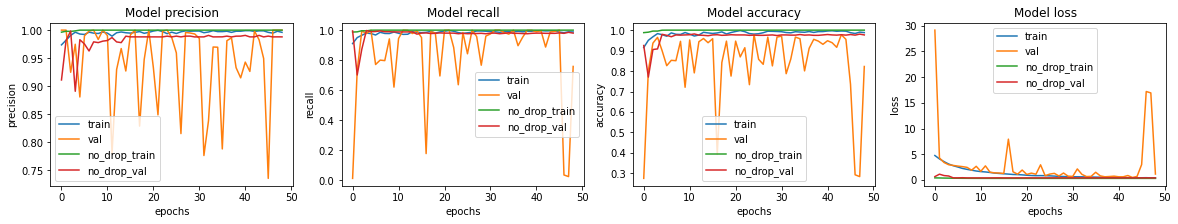

In [87]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].plot(history_no_drop_lr.history[met])
    ax[i].plot(history_no_drop_lr.history['val_' + met])
    
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val','no_drop_train', 'no_drop_val'])

In [88]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

5/5 [==============================] - 4s 774ms/step - loss: 2.7760 - accuracy: 0.7500 - precision: 0.7151 - recall: 0.9974
Loss: 2.7760438919067383,
Accuracy: 0.75,
Precision: 0.7150735259056091,
Recall: 0.9974358677864075


In [91]:
loss, acc, prec, rec = model.evaluate(test_ds)

5/5 [==============================] - 4s 732ms/step - loss: 2.7760 - accuracy: 0.7500 - precision: 0.7151 - recall: 0.9974


# 회고
### TPU 로 돌리려고 해보았으나, 자료형 (텐서형태로 입력되어야 함) 및 데이터 로드 과정에서 문제가 있었으며, 따라서 GPU 로 돌리게 되었다
### ImageDataGenerator 를 적절히 이용하여 model.fit 이전에 model.fit 을 시켰다. 그 결과 augmentation 이 잘 되었고 정확도가 올라가게 되었다. 그런데 어떤 기능은 쓰면 더 내려가는 경우가 있으므로
### 깊은 이해가 필요하다.
### False Positive(FP): 분류자가 부정 클래스를 긍정으로 잘못 예측한 예측의 수를 나타냅니다. 이것이 중요하므로, (TP+TN)/(TP+TN+FP+FN) 공식 인 accuracy 가 중요하다.
### drop 대신 learning rate scheduler 를 이용하였다 그 결과 정확도가 상승하였다.
### 점점 수렴하는 것을 lr scheduler 의 효과로 볼 수 있다.


